In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import playbyplayv2

# 1. Load data
df = pd.read_csv("game_prob.csv")

# 2. Features and target
X = df[["minute", "score_diff"]]
y = df["home_win"]

# 3. Train/test split by game
games = df["game_id"].unique()
train_games, test_games = train_test_split(games, test_size=0.2, random_state=42)

train_df = df[df["game_id"].isin(train_games)]
test_df = df[df["game_id"].isin(test_games)]

X_train = train_df[["minute", "score_diff"]]
y_train = train_df["home_win"]

X_test = test_df[["minute", "score_diff"]]
y_test = test_df["home_win"]

# 4. Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. Evaluate
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")



Train Accuracy: 0.716
Test Accuracy: 0.797


In [ ]:
nba_seasons = {
    "1996-97": {"games": 1189, "first_id": "0029600001"},
    "1997-98": {"games": 1189, "first_id": "0029700001"},
    "1998-99": {"games": 864,  "first_id": "0029800001"},  # lockout
    "1999-00": {"games": 1160, "first_id": "0029900001"},
    "2000-01": {"games": 1160, "first_id": "0020000001"},
    "2001-02": {"games": 1160, "first_id": "0020100001"},
    "2002-03": {"games": 1160, "first_id": "0020200001"},
    "2003-04": {"games": 1160, "first_id": "0020300001"},
    "2004-05": {"games": 1230, "first_id": "0020400001"},
    "2005-06": {"games": 1230, "first_id": "0020500001"},
    "2006-07": {"games": 1230, "first_id": "0020600001"},
    "2007-08": {"games": 1230, "first_id": "0020700001"},
    "2008-09": {"games": 1230, "first_id": "0020800001"},
    "2009-10": {"games": 1230, "first_id": "0020900001"},
    "2010-11": {"games": 1230, "first_id": "0021000001"},
    "2011-12": {"games": 990,  "first_id": "0021100001"},  # lockout
    "2012-13": {"games": 1230, "first_id": "0021200001"},
    "2013-14": {"games": 1230, "first_id": "0021300001"},
    "2014-15": {"games": 1230, "first_id": "0021400001"},
    "2015-16": {"games": 1230, "first_id": "0021500001"},
    "2016-17": {"games": 1230, "first_id": "0021600001"},
    "2017-18": {"games": 1230, "first_id": "0021700001"},
    "2018-19": {"games": 1230, "first_id": "0021800001"},
    "2019-20": {"games": 1059, "first_id": "0021900001"},  # covid
    "2020-21": {"games": 1080, "first_id": "0022000001"},  # covid
    "2021-22": {"games": 1230, "first_id": "0022100001"},
    "2022-23": {"games": 1230, "first_id": "0022200001"},
}
keys = list(nba_seasons.keys())
def makeDf(game_id):
    pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
    df = pbp.get_data_frames()[0]

    # Clean
    df = df.dropna(subset=["SCORE"])
    df[["h_pts", "a_pts"]] = df["SCORE"].str.split(" - ", expand=True).astype(int)

    # Convert clock → game minute
    def to_minute(period, clock):
        mins, secs = map(int, clock.split(":"))
        elapsed = (period-1)*12 + (12 - mins - secs/60)
        return int(elapsed) + 1

    df["minute"] = df.apply(lambda r: to_minute(r["PERIOD"], r["PCTIMESTRING"]), axis=1)

    return df
def makeMinuteDf(df):
    if df.empty or "h_pts" not in df.columns or df["minute"].max() is None:
        return pd.DataFrame()

    minutes = []

    max_minute = int(df["minute"].max())

    for m in range(1, max_minute+1):
        snapshot = df[df["minute"] <= m]
        if snapshot.empty:
            
            if m == 1:
                minutes.append([1, 0, 0, 0])
            continue
        h_pts = snapshot["h_pts"].max()
        a_pts = snapshot["a_pts"].max()
        score_diff = h_pts - a_pts
        minutes.append([m, h_pts, a_pts, score_diff])

    minute_df = pd.DataFrame(minutes, columns=["minute","h_pts","a_pts","score_diff"])

    # Target = final outcome
    final_h = df["h_pts"].max()
    final_a = df["a_pts"].max()
    winner = 1 if final_h > final_a else 0
    minute_df["home_win"] = winner

    return minute_df



In [32]:

def plot_game_win_prob(model, df, game_id):
    """
    Plot home team win probability for a given game_id as vertical bars
    with 0 as the midpoint and symmetric y-axis.

    Parameters:
        model : trained sklearn logistic regression
        df    : DataFrame containing minute-by-minute game data (must include 'game_id')
        game_id : str, the game_id to plot
    """
    # Extract game
    game_df = df[df["game_id"] == game_id]
    if game_df.empty:
        print(f"No data found for game_id {game_id}")
        return

    # Predict probabilities
    probs = model.predict_proba(game_df[["minute","score_diff"]])[:,1]

    # Scale probabilities to range -max_val to +max_val
    max_val = 150  
    scaled_probs = (probs - 0.5) * 2 * max_val  # -max_val to +max_val

    plt.figure(figsize=(12,6))

    # Draw bars from 0 (midpoint)
    for x, y in zip(game_df["minute"], scaled_probs):
        if y >= 0:
            plt.bar(x, y, bottom=0, color="blue", width=0.8)
        else:
            plt.bar(x, -y, bottom=y, color="red", width=0.8)

    # Midpoint line
    plt.axhline(0, color="gray", linestyle="--", label="equal score")

    # Overlay probability line (optional)
    plt.plot(game_df["minute"], scaled_probs, color="black", marker="o", label="lead")

    plt.title(f"lead tracker (Game {game_id})")
    plt.xlabel("Minute")
    plt.ylabel("points, home is bottom")
    plt.ylim(-max_val, max_val)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


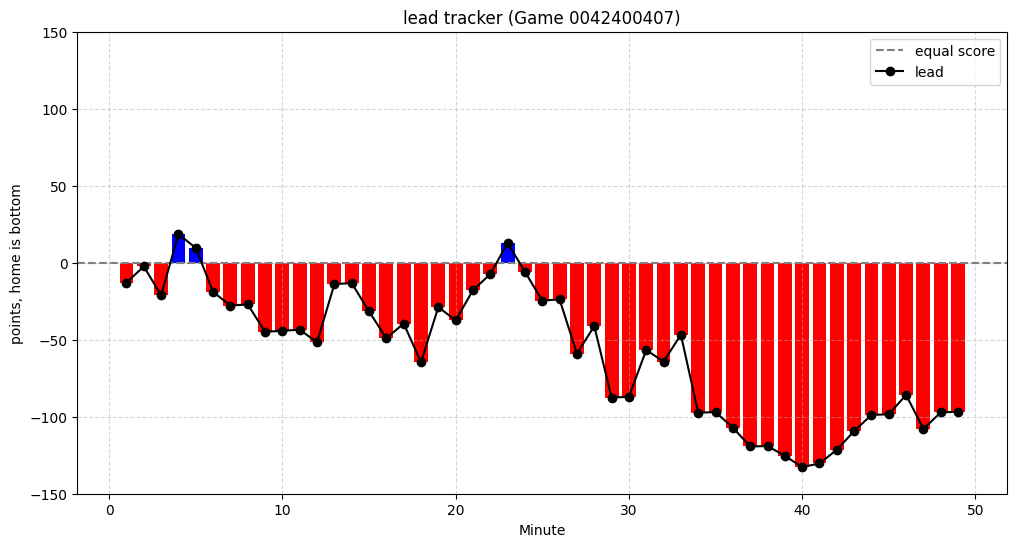

In [33]:
new_game_df = makeMinuteDf(makeDf("0042400407"))
new_game_df["game_id"] = "0042400407"  # add this column
plot_game_win_prob(model, new_game_df, "0042400407")
